In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tensorflow
from tensorflow import keras
from tqdm import tqdm
import pickle
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.applications import vgg16
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
tensorflow.__version__

'2.1.0'

In [3]:
data_path = "DATA_BASE\DATA_BASE_TRAIN_LARGER\IMAGES_PRESPROCESSED_LARGER\CLEAN"
img_size = 224
categories = ["AD", "CN", "LMCI"]

data = []

def creating_data():
    for category in categories:
        path = os.path.join(data_path,category)
        class_num = categories.index(category)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img) , cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (img_size, img_size))
            data.append([new_array, class_num])

    random.shuffle(data)

creating_data()
print(len(data))

print("train images")
print()
X_train = np.array([i[0] for i in data]).reshape(-1,img_size,img_size,3)
Y_train = np.array([i[1] for i in data])

#X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("Y_train.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()
print(X_train.shape)
print(Y_train.shape)

100%|██████████| 1384/1384 [00:00<00:00, 2494.25it/s]


3922
train images

(3922, 224, 224, 3)
(3922,)


In [4]:
data_path_test = "DATA_BASE\DATA_BASE_TEST\IMAGES_PREPROCESSED_TEST\CLEAN"
img_size = 224
categories = ["AD", "CN", "LMCI"]

data_test = []

def creating_data_test():
    for category in categories:
        path = os.path.join(data_path_test,category)
        class_num = categories.index(category)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img) , cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (img_size, img_size))
            data_test.append([new_array, class_num])

    random.shuffle(data_test)

creating_data_test()
print(len(data_test))

print("test images")
print()
X_test = np.array([i[0] for i in data_test]).reshape(-1,img_size,img_size,3)
Y_test = np.array([i[1] for i in data_test])

#X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("Y_test.pickle","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()
print(X_test.shape)
print(Y_test.shape)

100%|██████████| 273/273 [00:00<00:00, 2538.92it/s]


840
test images

(840, 224, 224, 3)
(840,)


In [5]:
from tensorflow.python.client import device_lib

In [6]:
# List available GPU devices
physical_devices = tensorflow.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth for the first GPU device
        tensorflow.config.set_logical_device_configuration(
            physical_devices[0],
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        #tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
        #print("Memory growth enabled for GPU")
    except RuntimeError as e:
        # Memory growth must be set before any initialization
        print(e)
else:
    print("No GPU found")


# Enable GPU memory growth to avoid memory allocation errors
physical_devices = tensorflow.config.list_physical_devices('GPU')
#tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)



device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3753797948708888171,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4963958784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13809374862324402058
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [7]:
tensorboard = TensorBoard(log_dir='./VGG16logs', histogram_freq=0,
                          write_graph=True, write_images=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [8]:
from tensorflow.keras.applications import VGG16

In [9]:

# Load the VGG16 base model
vgg16_base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg16_base_model.trainable = False  # Freeze the base model

# Define the input layer
inputs = tensorflow.keras.Input(shape=(224, 224, 3))

# Extract features using the base model
features_extracted = vgg16_base_model(inputs)

# Apply global average pooling
avg_pooling = layers.GlobalAveragePooling2D()(features_extracted)

# Add Dropout for regularization
dropout = layers.Dropout(0.5)(avg_pooling)

# Add the final Dense layer for classification
outputs = layers.Dense(3, activation='softmax')(dropout)

# Create the final model
final_model = Model(inputs, outputs)

# Print the model summary
final_model.summary()

# Check the type of the model
print(type(final_model))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________
<class 'tensorflow.python.keras.engine.training.Model'>


In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
# how many layers are in the base model?
print("Number of layers in the base model: ", len(vgg16_base_model.layers))

vgg16_layers = [layer.name for layer in vgg16_base_model.layers]
print(vgg16_layers)

Number of layers in the base model:  19
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [12]:
# swithcing on all layers to be trainable
vgg16_base_model.trainable = True

# swithcing off(freezing) all layers except the last 4 layers
fine_tune_last = 4
for layer in vgg16_base_model.layers[:-fine_tune_last]:
    layer.trainable = False

In [ ]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-5)
final_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [14]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 7,080,963
Non-trainable params: 7,635,264
_________________________________________________________________


In [15]:
history_fine = final_model.fit(X_train, Y_train, batch_size=16, epochs=20, validation_data=(X_test, Y_test))

Train on 3922 samples, validate on 840 samples
Epoch 1/20
3922/3922 [==============================] - 42s 11ms/sample - loss: 1.0205 - accuracy: 0.4638 - val_loss: 0.9505 - val_accuracy: 0.6060
Epoch 2/20
3922/3922 [==============================] - 34s 9ms/sample - loss: 0.7116 - accuracy: 0.7007 - val_loss: 0.8399 - val_accuracy: 0.6310
Epoch 3/20
3922/3922 [==============================] - 34s 9ms/sample - loss: 0.4724 - accuracy: 0.8327 - val_loss: 0.8494 - val_accuracy: 0.6083
Epoch 4/20
3922/3922 [==============================] - 34s 9ms/sample - loss: 0.3021 - accuracy: 0.9095 - val_loss: 0.8886 - val_accuracy: 0.6024
Epoch 5/20
3922/3922 [==============================] - 35s 9ms/sample - loss: 0.1945 - accuracy: 0.9457 - val_loss: 0.8464 - val_accuracy: 0.6643
Epoch 6/20
3922/3922 [==============================] - 35s 9ms/sample - loss: 0.1238 - accuracy: 0.9709 - val_loss: 0.8402 - val_accuracy: 0.6762
Epoch 7/20
3922/3922 [==============================] - 35s 9ms/sample

In [16]:
model_comparison = {}
model_comparison["vgg16"] = pd.DataFrame(history_fine.history)

In [17]:
EPOCHS = 30
def plot_performance(model_name, epochs = EPOCHS):
  dataframe = model_comparison[model_name]
  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(dataframe[["val_loss", "loss"]])
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Loss")
  plt.legend(["test", "train"])

  plt.subplot(1,2,2)
  plt.plot(dataframe[["val_accuracy", "accuracy"]])
  plt.legend(["test", "train"], loc = "lower right")
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Accuracy")

In [18]:
fine_tune_df = pd.DataFrame(history_fine.history)
model_comparison['vgg16_fineTuned'] = pd.concat([model_comparison['vgg16'],fine_tune_df]).reset_index()

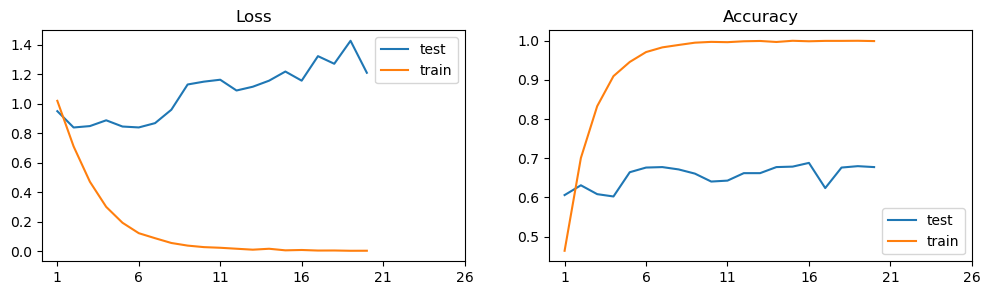

In [19]:
plot_performance('vgg16')

In [20]:
# Evaluate the model
scores = final_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

840/840 [==============================] - 11s 13ms/sample - loss: 1.2106 - accuracy: 0.6774
Test loss: 1.2105706918807257
Test accuracy: 0.677381


In [21]:
y_pred = final_model.predict(X_test, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_bool))

840/840 [==============================] - 6s 8ms/sample
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       291
           1       0.56      0.63      0.59       276
           2       0.59      0.60      0.59       273

    accuracy                           0.68       840
   macro avg       0.69      0.68      0.68       840
weighted avg       0.70      0.68      0.68       840



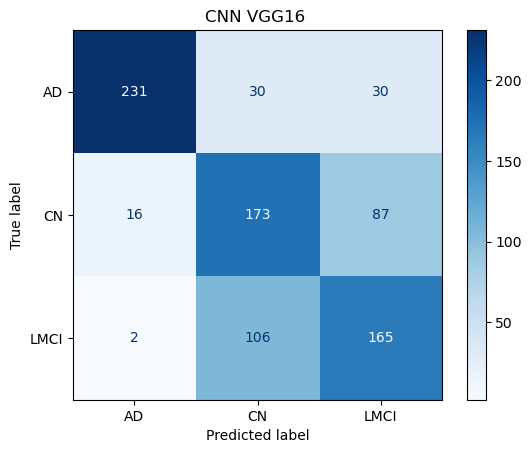

In [22]:
    # Calcular la matriz de confusión
    cm = confusion_matrix(Y_test, y_pred_bool)

    # Mostrar la matriz de confusión

    display_labels = ["AD", "CN", "LMCI"]
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots()

    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('CNN ' + 'VGG16 ')
    #plt.show()

    # Save the RF confusion matrix as a JPG image
    #plt.savefig("matriz_confusion_CNN_VGG16.jpg", format="jpg", bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [23]:
final_model.save("VGG16_3.h5")